In [4]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import spacy
import scattertext as st
import re

import spacy
#from spacy import displacy
#from spacy.symbols import amod
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.sklearn

import pandas as pd
import numpy as np

import swat
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
#nltk.download()
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

import pyflux as pf
from fbprophet import Prophet

In [7]:
with open('../../data/blogger_com_data_330677_11_clean_sentiment_v_pl_normalized.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [10]:
plutchik = df[['blogger_id', 'date','trust', 'fear', 'sadness',
       'anger', 'surprise', 'disgust', 'joy', 'anticipation']]

In [48]:
plutchik.columns[2:]

Index(['trust', 'fear', 'sadness', 'anger', 'surprise', 'disgust', 'joy',
       'anticipation'],
      dtype='object')

In [13]:
with open('../../data/blogger_com_data_330676_plutchik.pkl', 'wb') as picklefile:
    pickle.dump(plutchik, picklefile)

In [57]:
with open('../../data/blogger_com_data_330676_plutchik.pkl', 'rb') as picklefile:
    plutchik = pickle.load(picklefile)

In [58]:
def get_plutchik_data(df, blogger_id='4162441'):
    
    try:
    
        df_sub = df[df['blogger_id']==blogger_id].sort_values(by='date', ascending = True)

        if df_sub.shape[0] > 5:

            df_sub.drop('blogger_id', axis=1, inplace=True)
            df_sub.set_index('date', inplace=True)

            df_sub['trust_change'] = df_sub['trust'] - df_sub['trust'].shift(1)
            df_sub['fear_change'] = df_sub['fear'] - df_sub['fear'].shift(1)
            df_sub['sadness_change'] = df_sub['sadness'] - df_sub['sadness'].shift(1)
            df_sub['anger_change'] = df_sub['anger'] - df_sub['anger'].shift(1)
            df_sub['surprise_change'] = df_sub['surprise'] - df_sub['surprise'].shift(1)
            df_sub['disgust_change'] = df_sub['disgust'] - df_sub['disgust'].shift(1)
            df_sub['joy_change'] = df_sub['joy'] - df_sub['joy'].shift(1)
            df_sub['anticipation_change'] = df_sub['anticipation'] - df_sub['anticipation'].shift(1)

            df_sub = df_sub.iloc[1:].reset_index()
            
            df1 = pd.melt(df_sub, id_vars=['date'], value_vars=['trust', 'fear', 'sadness',
                                                                'anger', 'surprise', 'disgust', 
                                                                'joy', 'anticipation'])
            df2 = pd.melt(df_sub, id_vars=['date'], value_vars=['trust_change', 'fear_change', 'sadness_change',
                                                                'anger_change', 'surprise_change', 'disgust_change', 
                                                                'joy_change', 'anticipation_change'], 
                          value_name='change')
            
            df1 = df1.sort_values(by=['date'])
            df2['variable'] = df2['variable'].str.replace('_change', '')
            new_df = pd.merge(df1, df2,  how='left', left_on=['date','variable'], right_on = ['date','variable'])
            new_df.dropna(axis=0, inplace=True)
            
            df_sub = new_df.sort_values('date')

            return df_sub

        else:

            print('Sorry, not enough posts yet, make it up to 6.')
    except:
        
        print('Sorry, do not see your ID in the ststem.')
        

In [59]:
blogger_id = '1270648'

In [60]:
df[df['variable'] == 'trust']['date'],

(0    2004-08-09
 12   2004-08-14
 18   2004-08-16
 26   2004-08-17
 37   2004-08-19
 Name: date, dtype: datetime64[ns],)

In [61]:
df = get_plutchik_data(plutchik, blogger_id='4162441')
df

,date,variable,value,change
0,2004-08-09,trust,0.000302,-0.002117
1,2004-08-09,joy,0.000302,-0.003024
2,2004-08-09,disgust,0.001814,0.000907
3,2004-08-09,fear,0.002419,0.001814
4,2004-08-09,surprise,0.000302,-0.000605
5,2004-08-09,anger,0.001814,0.001210
6,2004-08-09,anticipation,0.001512,-0.000302
7,2004-08-09,sadness,0.003931,0.003629
15,2004-08-14,fear,0.000000,-0.002419
14,2004-08-14,sadness,0.000000,-0.003931


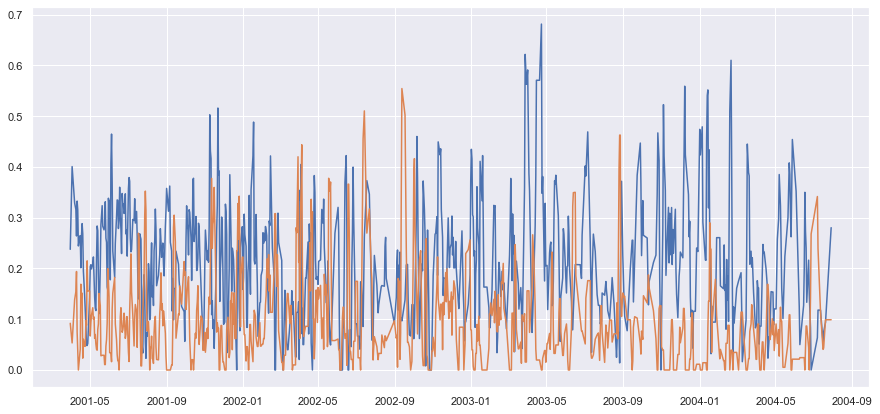

In [251]:
plt.figure(figsize=(15,7))
plt.plot(df.index, df['MA_pos'])
plt.plot(df.index, df['MA_neg']);

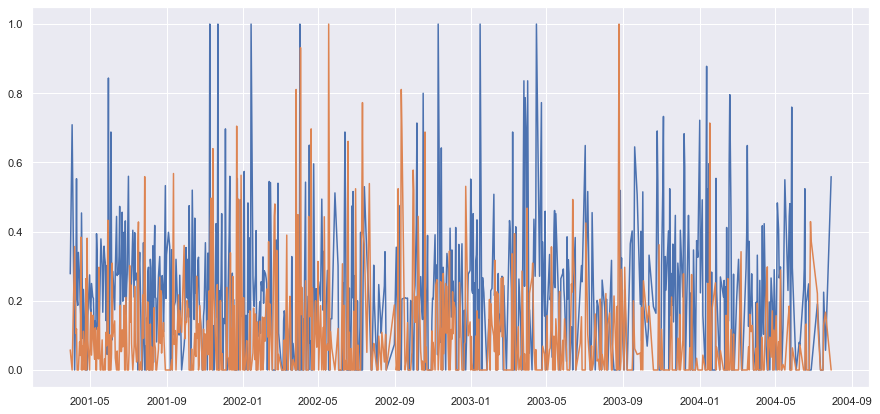

In [252]:
plt.figure(figsize=(15,7))
plt.plot(df.index, df['polarity_pos_posts'])
plt.plot(df.index, df['polarity_neg_post']);

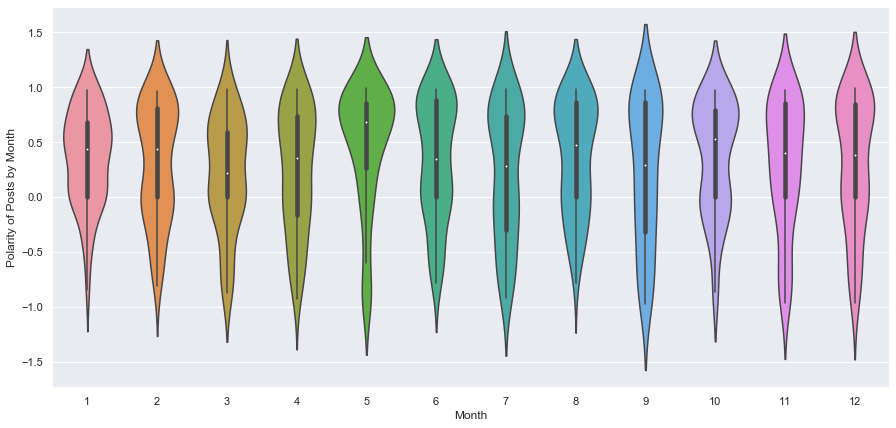

In [253]:
# violinplot months to determine variance and range
plt.figure(figsize=(15,7))
sns.set()
sns.violinplot(x=df.index.month, y=df.polarity_compound_post)
plt.xlabel("Month")
plt.ylabel("Polarity of Posts by Month");

# Profet

In [254]:
df

,polarity_neg_post,polarity_pos_posts,polarity_compound_post,MA_pos,MA_neg
date,,,,,
2001-03-31,0.058,0.278,0.9803,0.237667,0.092000
2001-04-03,0.000,0.709,0.9042,0.400667,0.053333
2001-04-07,0.357,0.000,-0.7371,0.329000,0.138333
2001-04-09,0.106,0.239,0.7430,0.316000,0.154333
2001-04-10,0.119,0.553,0.8625,0.264000,0.194000
...,...,...,...,...,...
2004-07-12,0.000,0.000,0.0000,0.118000,0.114333
2004-07-16,0.000,0.000,0.0000,0.054333,0.040667
2004-07-17,0.130,0.225,0.7351,0.075000,0.043333


In [259]:
def fb_profet(df, n_col=2):
    
    df_profet = df.iloc[:,n_col].reset_index()
    df_profet.rename(columns={'date':'ds', df_profet.columns[1]:'y'}, inplace=True)
    
    model = Prophet()
    model.fit(df_profet);
    
    future = model.make_future_dataframe(periods=35)
    forecast = model.predict(future)
    
    return model, forecast
    

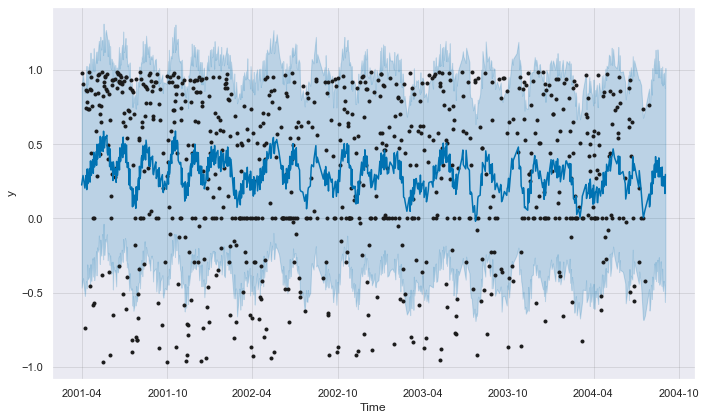

In [260]:
model, forecast = fb_profet(df, n_col=2)

model.plot(forecast, xlabel='Time');

In [163]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-08-16,0.193905,0.139755,0.244039,0.193905,0.193905,0.0,0.0,0.0,0.0,0.0,0.0,0.193905
1,2004-08-18,0.188744,0.135274,0.239594,0.188744,0.188744,0.0,0.0,0.0,0.0,0.0,0.0,0.188744
2,2004-08-19,0.186164,0.133935,0.236838,0.186164,0.186164,0.0,0.0,0.0,0.0,0.0,0.0,0.186164
3,2004-08-21,0.181004,0.127505,0.233301,0.181004,0.181004,0.0,0.0,0.0,0.0,0.0,0.0,0.181004
4,2004-08-22,0.178424,0.129526,0.231134,0.178424,0.178424,0.0,0.0,0.0,0.0,0.0,0.0,0.178424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,2005-08-18,-0.753018,-0.806278,-0.700042,-0.753020,-0.753016,0.0,0.0,0.0,0.0,0.0,0.0,-0.753018
366,2005-08-19,-0.755598,-0.803542,-0.701722,-0.755601,-0.755596,0.0,0.0,0.0,0.0,0.0,0.0,-0.755598
367,2005-08-20,-0.758179,-0.808927,-0.712259,-0.758181,-0.758176,0.0,0.0,0.0,0.0,0.0,0.0,-0.758179
368,2005-08-21,-0.760759,-0.810552,-0.706778,-0.760761,-0.760757,0.0,0.0,0.0,0.0,0.0,0.0,-0.760759


# Pyflux

In [ ]:
#model = pf.ARIMAX(data=df,formula='y~1',ar=2,ma=0, integ=1)
#fit_model = model.fit()

In [215]:
# def ts_pyflux(df, n_col=2):
    
#     df_pyflux = df.iloc[:,n_col].reset_index()
#     df_pyflux.rename(columns={'date':'ds', df_pyflux.columns[1]:'y'}, inplace=True)
    
#     model = pf.ARIMAX(data=df_pyflux,formula='y~1',ar=2,ma=0, integ=1)
#     fit_model = model.fit()
    
    
    
#     return model.plot_fit(figsize=(15,5))#model.plot_predict(h=10, oos_data=df_pyflux, figsize=(15,5))

In [243]:
# ts_pyflux(df, n_col=2)

In [244]:

# df_pyflux = df.iloc[:,0].reset_index()
# df_pyflux.rename(columns={'date':'ds', df_pyflux.columns[1]:'y'}, inplace=True)
# df_pyflux

In [245]:
# df_pyflux.iloc[-df_pyflux.shape[0]:]

In [246]:
# model = pf.ARIMAX(data=df_pyflux,formula='y~1',ar=2,ma=0, integ=1)

# fit_model = model.fit()
    
# model.plot_predict(h=1,oos_data=df_pyflux.iloc[-df_pyflux.shape[0]:])

In [247]:
# df_pyflux.iloc[-df_pyflux.shape[0]:]

In [248]:
# df_pyflux.shape[0]

In [205]:
# df_pyflux = df.iloc[:,n_col].reset_index()
# df_pyflux.rename(columns={'date':'ds', df_profet.columns[1]:'y'}, inplace=True)